### Plot Function

In [193]:
import matplotlib.pyplot as plt
titles = [
        "Pressure",
        "Temperature",
        "Temperature in Kelvin",
        "Temperature (dew point)",
        "Relative Humidity",
        "Saturation vapor pressure",
        "Vapor pressure",
        "Vapor pressure deficit",
        "Specific humidity",
        "Water vapor concentration",
        "Airtight",
        "Wind speed",
        "Maximum wind speed",
        "Wind direction in degrees",
        "Rainfall (in millimeters)",
        "Raining duration (in seconds)",
        "Solar Radiation (in watts per square meter)",
        "Photosynthetically Active Radiation (in micromoles per square meter per second)",
        "Maximum Photosynthetically Active Radiation (in micromoles per square meter per second)",
        "Logged Temperature (in degrees Celsius)",
        "Carbon Dioxide Concentration (in parts per million)"
]

def plot(data, titles):
    n_cols = 2
    n_rows = (len(data.columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 22), sharex=False)
    axes = axes.flatten()

    for i, column, in enumerate(data.columns):

        axes[i].plot(data.index, data[column], label=column)
        axes[i].set_title(f'{titles[i]} {column}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].grid(True)
        axes[i].legend()
        
    # Hide any unused subplots
    for j in range(len(data.columns), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

### Plot Initial Resampled Data

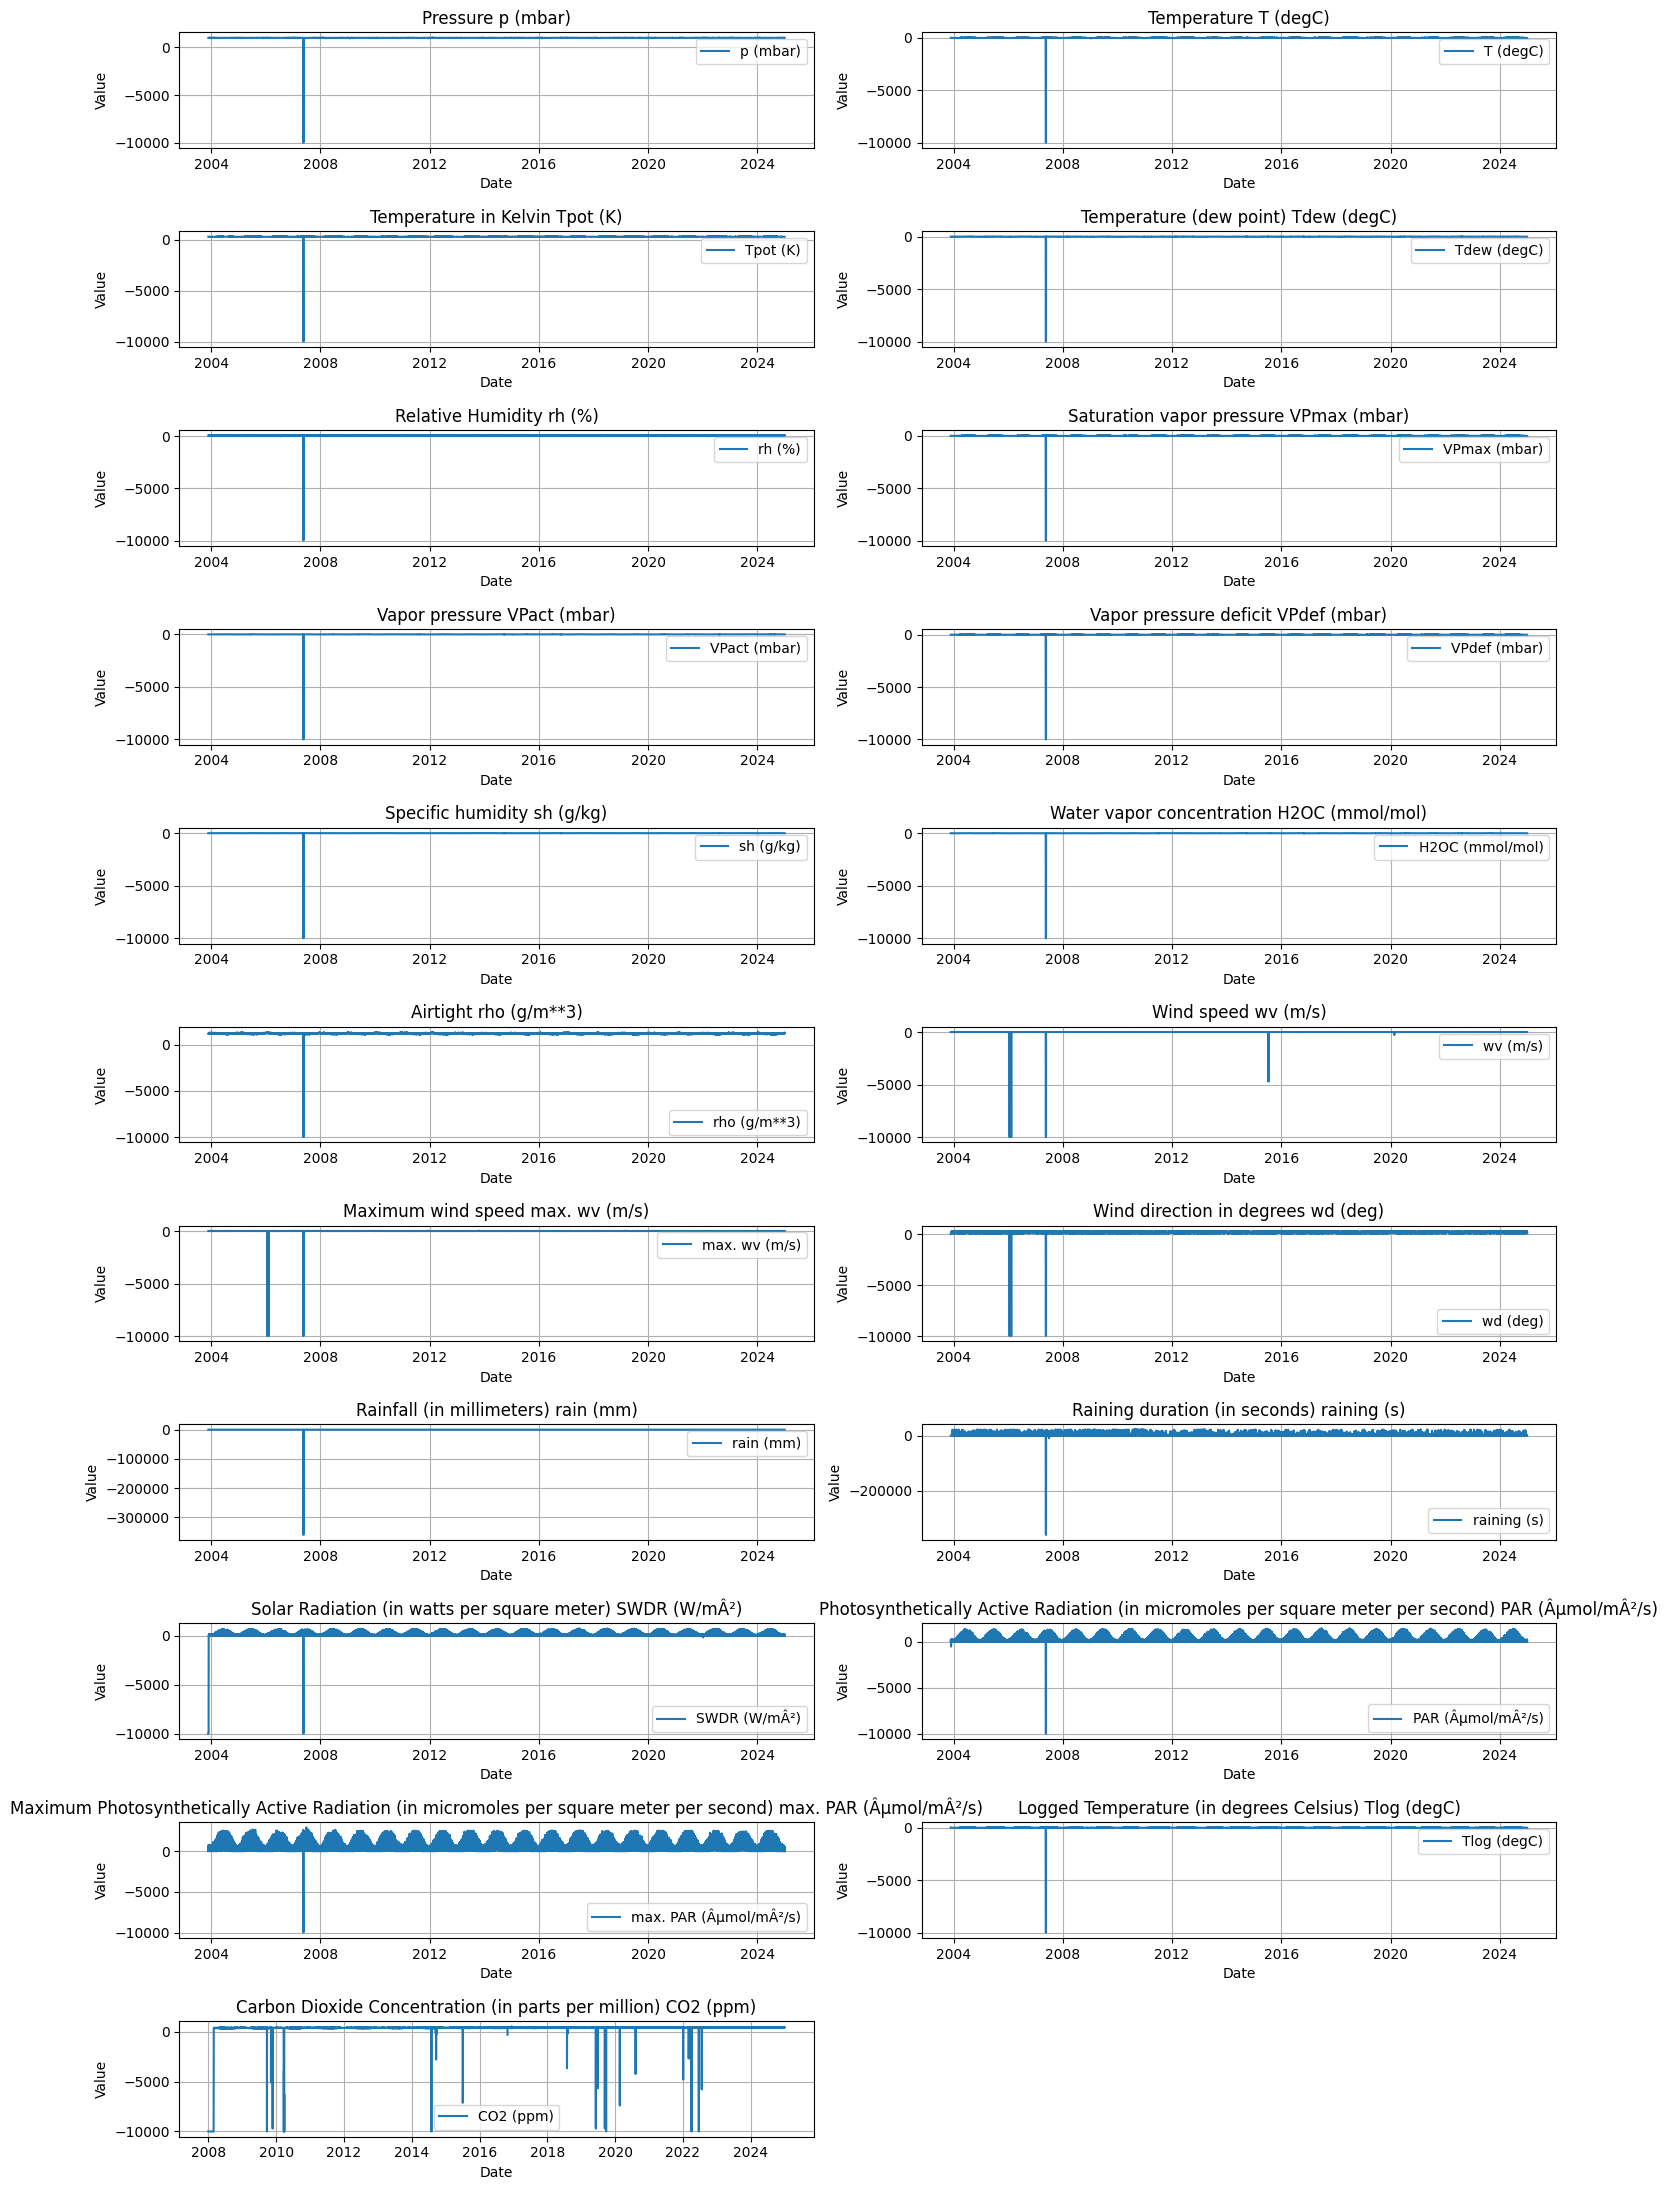

In [194]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

data = pd.read_csv("../processed/mpi_roof.csv", encoding='latin-1')
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
data = data.set_index("Date Time")
resample_data = pd.DataFrame()
sum_column = ['rain (mm)', 'raining (s)']
max_column = ['max. wv (m/s)', 'max. PAR (Âµmol/mÂ²/s)']
for i in data.columns:
    if i in sum_column:
        resample_data[i] = data[i].resample('6h').sum()
    elif i in max_column:
        resample_data[i] = data[i].resample('6h').max()
    else:
        resample_data[i] = data[i].resample('6h').mean()
plot(resample_data, titles)


### Giải thích: Tất cả các đặc trưng của dataset đều không thể xác định được xu hướng do lỗi về đọc dữ liệu của sensor. Trong đó, các đại lượng đo sai đều đạt giá trị âm rất lớn nên biểu đồ không thể diễn tả xu hướng bằng mắt một cách rõ ràng. Điểm chung của hầu hết đặc trưng gặp error_sensor đều tập trung vào khoảng thời điểm gần năm 2008.

### Check Initial Resampled Nan Values

In [195]:
print('Nan sum: ', resample_data.isna().sum())

Nan sum:  p (mbar)                    15
T (degC)                    15
Tpot (K)                    15
Tdew (degC)                 15
rh (%)                      15
VPmax (mbar)                15
VPact (mbar)                15
VPdef (mbar)                15
sh (g/kg)                   15
H2OC (mmol/mol)             15
rho (g/m**3)                15
wv (m/s)                    15
max. wv (m/s)               15
wd (deg)                    15
rain (mm)                    0
raining (s)                  0
SWDR (W/mÂ²)                15
PAR (Âµmol/mÂ²/s)           15
max. PAR (Âµmol/mÂ²/s)      15
Tlog (degC)                 15
CO2 (ppm)                 6009
dtype: int64


### Fill Nan Values

In [196]:
resample_row = resample_data.shape[0]

#Check for nan values in the resampled dataset
for i in resample_data.columns:
    resample_data[i] = resample_data[i].interpolate(method='linear', limit_direction='both')

print('Nan sum: ', resample_data.isna().sum())  



Nan sum:  p (mbar)                  0
T (degC)                  0
Tpot (K)                  0
Tdew (degC)               0
rh (%)                    0
VPmax (mbar)              0
VPact (mbar)              0
VPdef (mbar)              0
sh (g/kg)                 0
H2OC (mmol/mol)           0
rho (g/m**3)              0
wv (m/s)                  0
max. wv (m/s)             0
wd (deg)                  0
rain (mm)                 0
raining (s)               0
SWDR (W/mÂ²)              0
PAR (Âµmol/mÂ²/s)         0
max. PAR (Âµmol/mÂ²/s)    0
Tlog (degC)               0
CO2 (ppm)                 0
dtype: int64


### Transform Data and Modify the Sensor-Error Values

In [197]:
#Conver from C to K
resample_data['T (degC)'] = resample_data['T (degC)'] + 273.15
resample_data['Tdew (degC)'] = resample_data['Tdew (degC)'] + 273.15
resample_data['Tlog (degC)'] = resample_data['Tlog (degC)'] + 273.15

resample_data.rename(columns={'T (degC)': 'T (K)'}, inplace=True)
resample_data.rename(columns={'Tdew (degC)': 'Tdew (K)'}, inplace=True)
resample_data.rename(columns={'Tlog (degC)': 'Tlog (K)'}, inplace=True)

#Replace negative numbers
replace_data = resample_data
replace_data['T (K)'] = replace_data['T (K)'].apply(lambda x: np.nan if x < 243.15 else x)
replace_data['Tdew (K)'] = replace_data['Tdew (K)'].apply(lambda x: np.nan if x < 243.15 else x)
replace_data['Tpot (K)'] = replace_data['Tpot (K)'].apply(lambda x: np.nan if x < 243.15 else x)
replace_data['Tlog (K)'] = replace_data['Tlog (K)'].apply(lambda x: np.nan if x < 243.15 else x)

resample_data[['T (K)', 'Tdew (K)', 'Tpot (K)', 'Tlog (K)']] = replace_data[['T (K)', 'Tdew (K)', 'Tpot (K)', 'Tlog (K)']]
replace_data = replace_data.drop(columns=['T (K)', 'Tdew (K)', 'Tpot (K)', 'Tlog (K)'])

for i in replace_data.columns:
    resample_data[i] = replace_data[i].apply(lambda x: 0 if x < 0 else x)

#Check for nan values in the resampled dataset
for i in resample_data.columns:
    resample_data[i] = resample_data[i].interpolate(method='linear', limit_direction='both')



### Plot the Modified Data

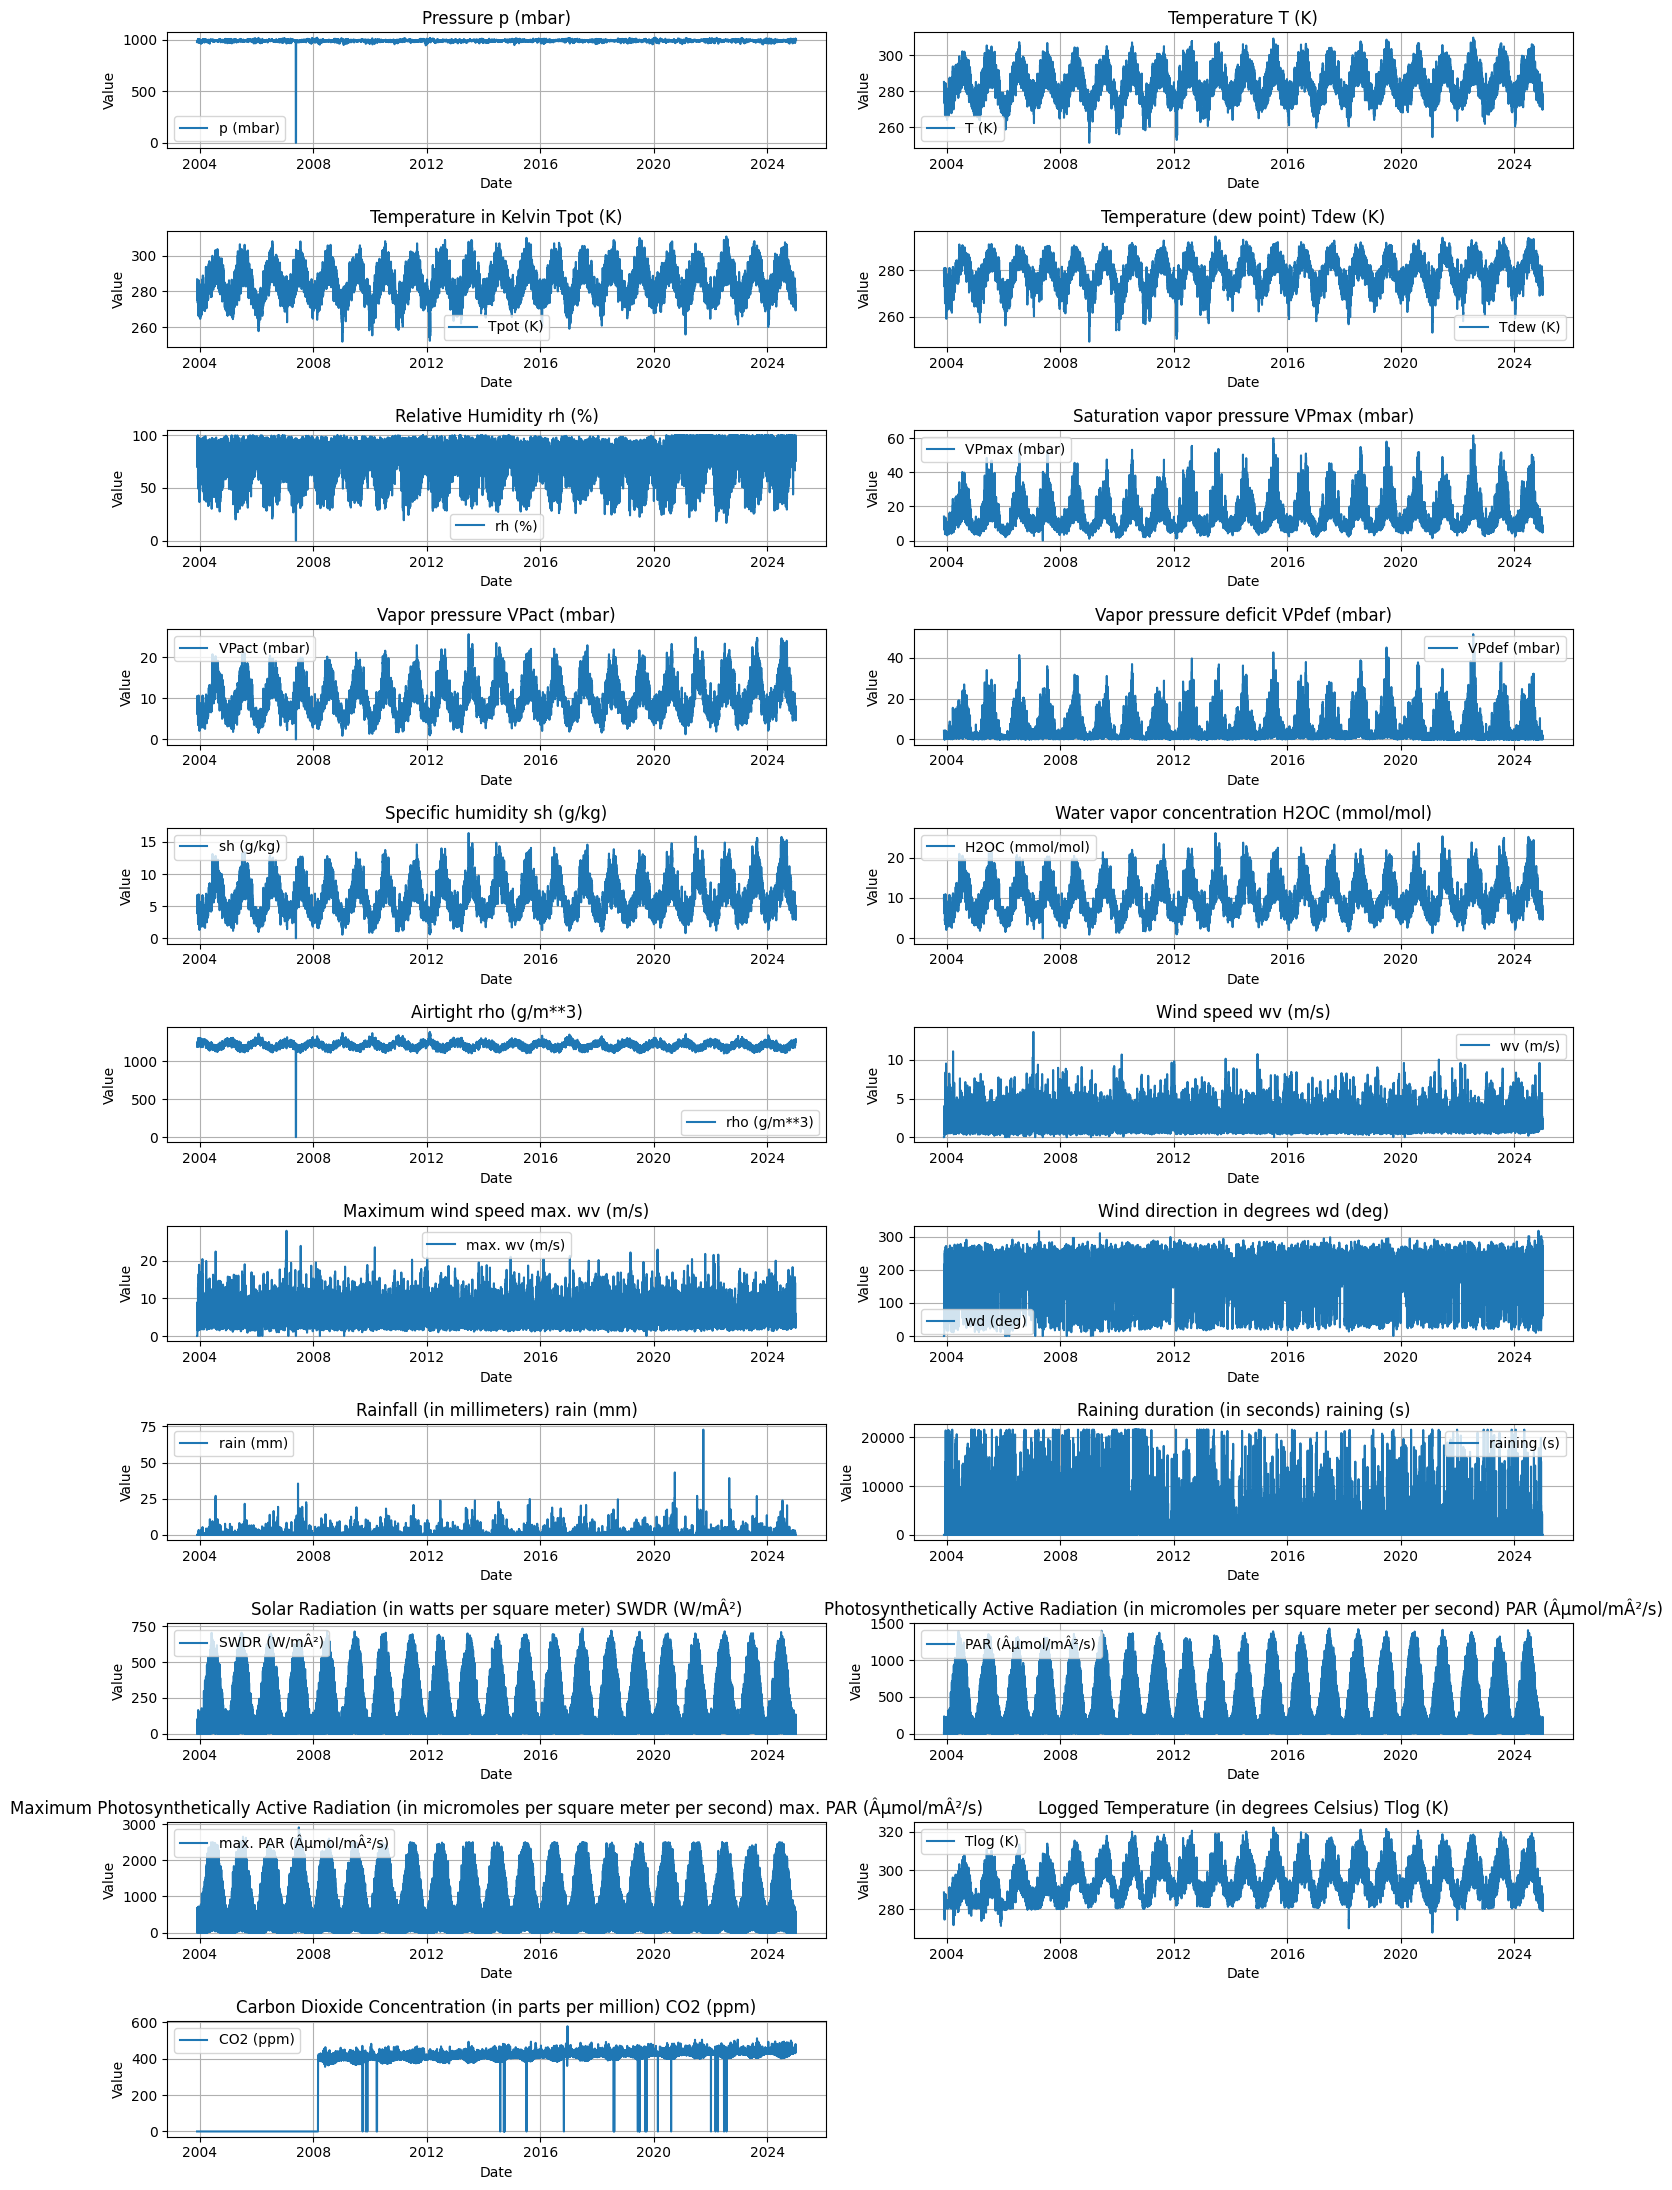

In [198]:
plot(resample_data, titles)

### Giải thích: Dữ liệu sau khi chỉnh sửa trở nên dễ nhìn và dễ phát hiện xu hướng hơn dữ liệu cũ. Điều này giúp máy có thể học được các xu hướng một cách dễ dàng hơn thay cho dữ liệu cũ. Tuy nhiên vẫn có các outlier ở một số đặc trưng như nhiệt độ, rho có thể một phần do sự điều chỉnh ở các đặc trưng bị sensor-error.

### Add Rain Rate, Is Rain and Rain Type Columns

In [199]:
resample_data['Rain_Rate (mm/h)'] = np.where((resample_data['raining (s)'] > 0), (resample_data['rain (mm)'] * 3600) / resample_data['raining (s)'], 0)
resample_data['Is_Rain'] = np.where(resample_data['Rain_Rate (mm/h)'] >= 0.5, 'Yes', 'No')

rain_condition = ['No_Rain', 'Weak_Rain', 'Moderate_Rain', 'Heavy_Rain', 'Very_Heavy_Rain', 'Shower', 'Cloudburst']
rain_rate = [resample_data['Rain_Rate (mm/h)'] < 0.5,
             (resample_data['Rain_Rate (mm/h)'] >= 0.5) & (resample_data['Rain_Rate (mm/h)'] < 2),
             (resample_data['Rain_Rate (mm/h)'] >= 2) & (resample_data['Rain_Rate (mm/h)'] < 6),
             (resample_data['Rain_Rate (mm/h)'] >= 6) & (resample_data['Rain_Rate (mm/h)'] < 10),
             (resample_data['Rain_Rate (mm/h)'] >= 10) & (resample_data['Rain_Rate (mm/h)'] < 18),
             (resample_data['Rain_Rate (mm/h)'] >= 18) & (resample_data['Rain_Rate (mm/h)'] < 30),
             resample_data['Rain_Rate (mm/h)'] >= 30]
resample_data['Rain_Type'] = np.select(rain_rate, rain_condition, default='Unknown')

### Plot Annual Rain Rate

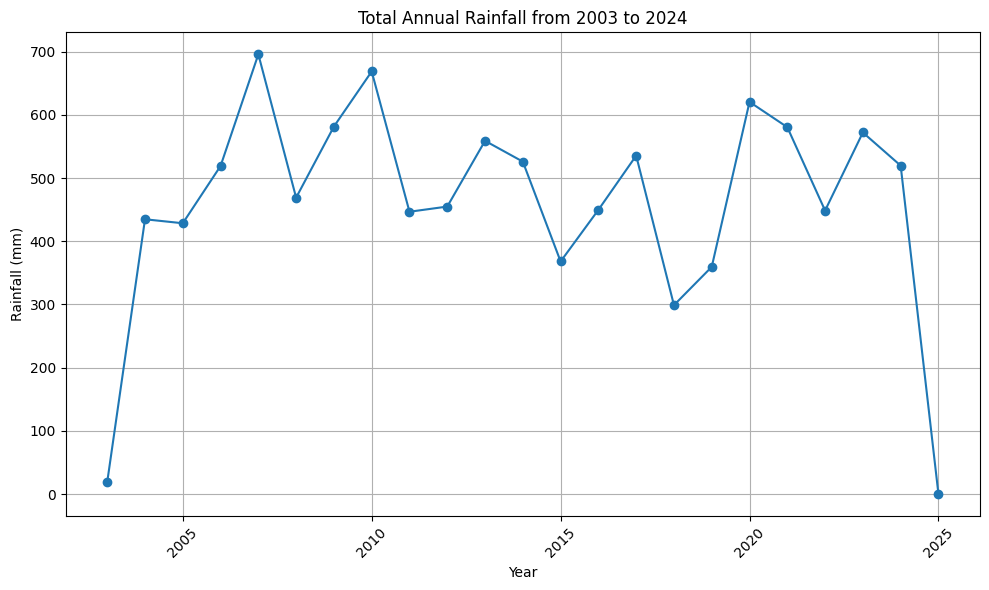

In [200]:
annual_rain = resample_data.copy(deep=True)
annual_rain['year'] = annual_rain.index.year

annual_rain_rate = annual_rain.groupby('year')['rain (mm)'].sum()

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(annual_rain_rate.index, annual_rain_rate.values, marker='o', linestyle='-')
plt.title('Total Annual Rainfall from 2003 to 2024')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Biểu đồ đường về tổng lượng mưa hằng năm từ 2003 - 1/1/2025
Biểu đồ lượng mưa từ năm 2003 đến 2024 cho thấy xu hướng biến động mạnh. Lượng mưa tăng nhanh giai đoạn đầu và đạt đỉnh năm 2007, sau đó dao động thất thường qua các năm. Giai đoạn 2020–2023 khá ổn định, nhưng đến năm 2024 bất ngờ giảm gần bằng 0 mm, có thể do sự điều chỉnh dữ liệu do error-sensor hoặc hiện tượng thời tiết cực đoan.


### Average Monthly Rain Rate from 2003 - 2024

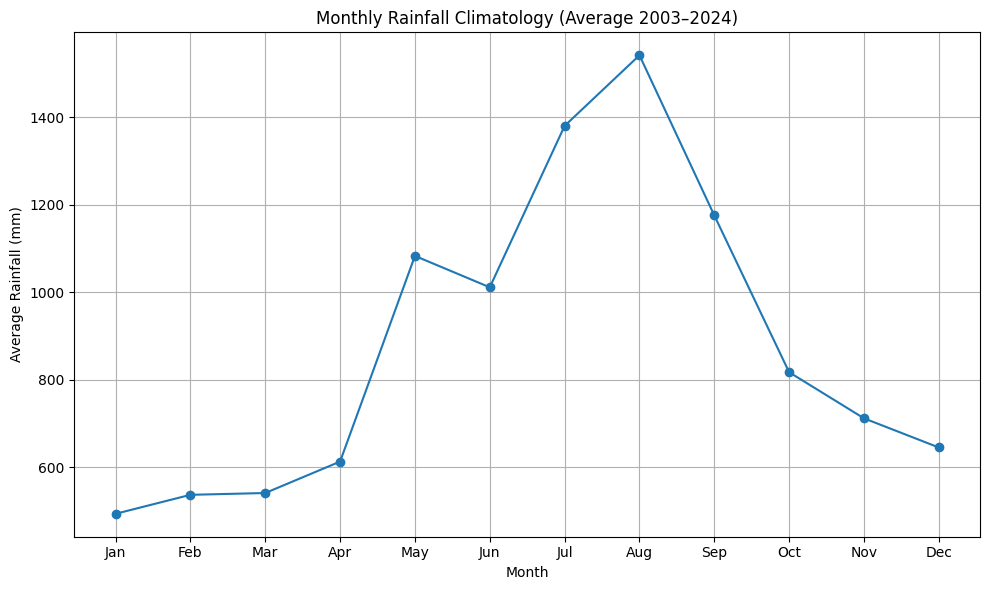

In [201]:
monthly_data = resample_data.copy(deep=True)
monthly_data['month'] = monthly_data.index.month
monthly_climatology = monthly_data.groupby('month')['rain (mm)'].sum()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_climatology.index, monthly_climatology.values, marker='o', linestyle='-')
plt.title('Monthly Rainfall Climatology (Average 2003–2024)')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

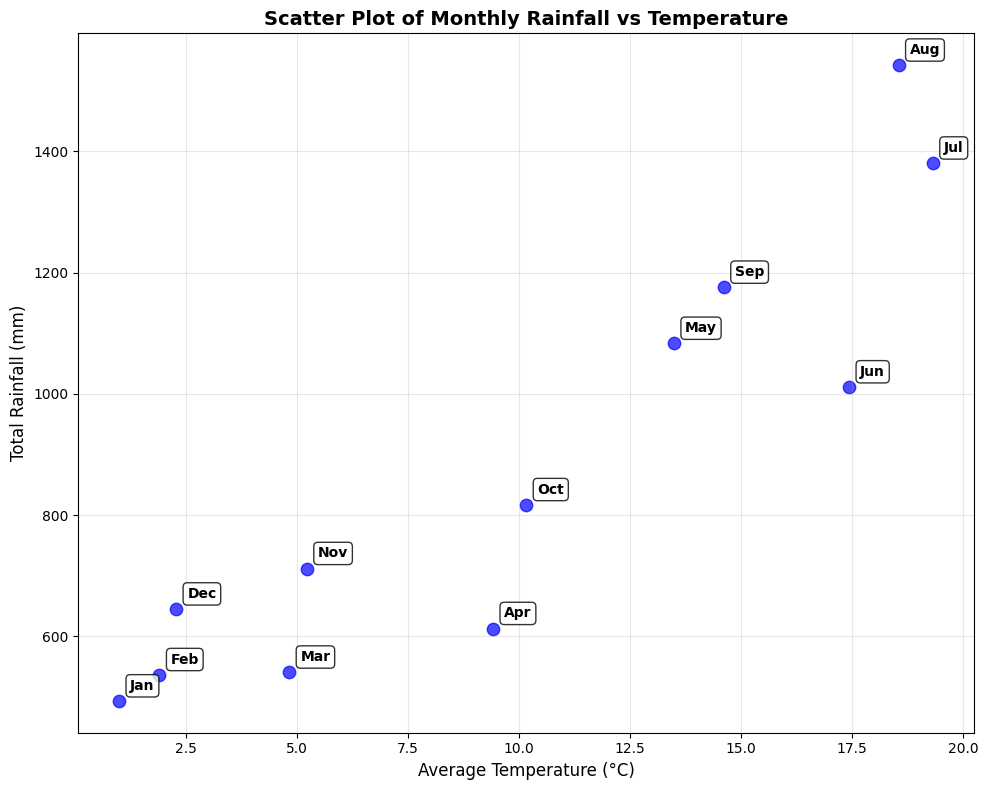

In [202]:
monthly_data = resample_data.copy(deep=True)
monthly_data['month'] = monthly_data.index.month
monthly_data['T (degC)'] = monthly_data['T (K)'] - 273.15

monthly_avg = monthly_data.groupby('month').agg({
    'rain (mm)': 'sum',
    'T (degC)': 'mean'
}).reset_index()

# Create month names for better readability
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg['month_name'] = monthly_avg['month'].apply(lambda x: month_names[x-1])

# Scatter plot with month labels
plt.figure(figsize=(10, 8))
plt.scatter(monthly_avg['T (degC)'], monthly_avg['rain (mm)'], color='blue', s=80, alpha=0.7)

# Add month labels to each point
for i, row in monthly_avg.iterrows():
    plt.annotate(row['month_name'], 
                (row['T (degC)'], row['rain (mm)']),
                xytext=(8, 8), textcoords='offset points', 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.title('Scatter Plot of Monthly Rainfall vs Temperature', fontsize=14, fontweight='bold')
plt.xlabel('Average Temperature (°C)', fontsize=12)
plt.ylabel('Total Rainfall (mm)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Giải thích:
- Biểu đồ đường thể hiện lượng mưa tổngtổng hằng tháng từ 2003 - 2024
- Biểu đồ scatter thể hiện mối quan hệ giữa lượng mưa tổng với nhiệt độ trung bình hằng tháng từ 2004 - 2024
- Hai biểu đồ cho thấy đặc điểm khí hậu ôn đới lục địa điển hình của Đức với nhiệt độ dao động từ 1°C (mùa đông) đến 19.5°C (mùa hè). Dữ liệu climatology từ 2003-2024 thể hiện chu kỳ mùa vụ rõ rệt: mùa đông khô nhất với lượng mưa chỉ 500-550mm, tăng dần qua mùa xuân và đạt đỉnh vào tháng 8 (~1500mm) do mưa giông mùa hè. Sự chênh lệch lượng mưa giữa mùa khô và mùa ẩm lên đến 2.5-3 lần phản ánh tính mùa vụ mạnh của khí hậu Đức. Biểu đồ scatter plot cho thấy mối quan hệ phức tạp giữa nhiệt độ và lượng mưa, không đơn thuần tăng tuyến tính mà thể hiện đặc trưng khí hậu lục địa với mùa đông lạnh khô và mùa hè ấm ẩm.

### Rainy Days per Year Plot

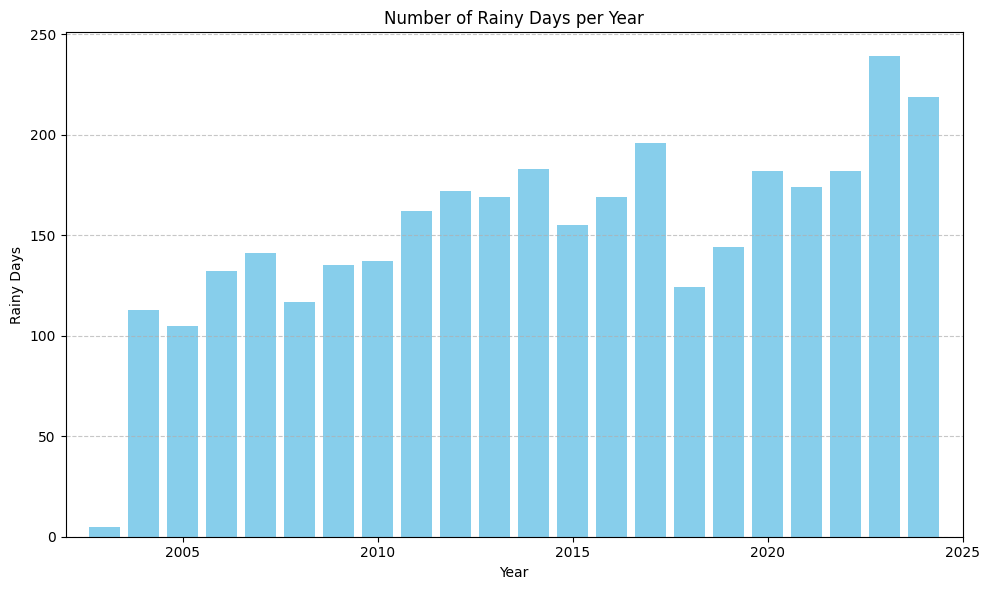

In [203]:
# Define a rainy day (e.g., rainfall > 0 mm)
rainy_days = resample_data[resample_data['Is_Rain'] != 'No'].copy(deep=True)

# Extract year
rainy_days['year'] = rainy_days.index.year

# Count rainy days per year
rainy_days_per_year = rainy_days.groupby('year').size()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(rainy_days_per_year.index, rainy_days_per_year.values, color='skyblue')
plt.title('Number of Rainy Days per Year')
plt.xlabel('Year')
plt.ylabel('Rainy Days')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: Set year limits
plt.xlim(rainy_days_per_year.index.min() - 1, rainy_days_per_year.index.max() + 1)

plt.tight_layout()
plt.show()


### Preprocess Data

In [204]:
is_rain = resample_data.drop(columns=['Rain_Type'])
resample_data.head()
is_rain.to_csv("../processed/is_rain.csv")

#Preprocessing data
scaler = StandardScaler()
robust = RobustScaler()
encoder = OneHotEncoder(sparse_output=False)
regression_data = resample_data.drop(columns=['Is_Rain', 'Rain_Type'])
categorical_columns = resample_data.select_dtypes(include=['object']).columns.tolist()

one_hot_encoded = encoder.fit_transform(resample_data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=resample_data.index)

regression_data_scaler = scaler.fit_transform(regression_data)
regression_data_df = pd.DataFrame(regression_data_scaler, columns=regression_data.columns, index=regression_data.index)

preprocessed_data = pd.concat([regression_data_df, one_hot_df], axis=1)
preprocessed_data.head()
preprocessed_data = preprocessed_data.drop(columns=['Is_Rain_No', 'Is_Rain_Yes'])
# preprocessed_data = preprocessed_data.dropna()
preprocessed_data.to_csv("../processed/rain_type.csv")